# Challenge: Get the best results on the [fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset!

> "Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits."

<img src="https://raw.githubusercontent.com/zalandoresearch/fashion-mnist/master/doc/img/fashion-mnist-sprite.png">


TASK - Challenge: Get the best results on the fashionMNIST dataset!

The challenge of this task is to get the best results on the fashionMNIST dataset by tuning hyperparameters of the model and observing convergence behavior.

"Best" - for simplicity - means the highest accuracy on the validation set.

"Rules":

    You can change any hyperparameters,
    including the number of layers,
    width of the layers,
    activation functions,
    regularizers (and their parameters),
    optimizer (and it's parameters), but
    you should not change the model architecture, use only fully connected layers! (Even if you know any others... :-P

Added constraint: The model with the "best performance" has to be saved, so it should not be just a printout happening once during training!

And: You may NOT manipulate the validation set! :-P

Happy coding! :-)


# Loading the data

In [1]:
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz
! wget http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz

--2019-04-07 16:06:30--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.110
Connecting to fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)|52.219.74.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26421880 (25M) [binary/octet-stream]
Saving to: ‘train-images-idx3-ubyte.gz.4’

train-images-idx3-u 100%[===================>]  25.20M  15.8MB/s    in 1.6s    

2019-04-07 16:06:32 (15.8 MB/s) - ‘train-images-idx3-ubyte.gz.4’ saved [26421880/26421880]

--2019-04-07 16:06:33--  http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz
Resolving fashion-mnist.s3-website.eu-central-1.amazonaws.com (fashion-mnist.s3-website.eu-central-1.amazonaws.com)... 52.219.74.110
Connecting to fashion-mnist.s3-website.eu-central-1.

In [0]:
import numpy as np
import os
import gzip

def load_mnist(path, kind='train'):
    """Load MNIST data from `path`.
    """
    labels_path = os.path.join(path,'%s-labels-idx1-ubyte.gz' % kind)
    images_path = os.path.join(path,'%s-images-idx3-ubyte.gz' % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [3]:
train_images, train_labels = load_mnist('.')

# because of some limitations of Keras's softmax implementation, it's 
# advisable to normalise the images by dividing the intensities by the
# maximal 255 value
train_images = train_images / 255.

valid_test_images, valid_test_labels = load_mnist('.', 't10k')

valid_test_images = valid_test_images / 255. # the same normalization for valid and test

valid_images = valid_test_images[:5000]
valid_labels = valid_test_labels[:5000]
test_images = valid_test_images[5000:]
test_labels = valid_test_labels[5000:]

print(train_images.shape, valid_images.shape, test_images.shape)

(60000, 784) (5000, 784) (5000, 784)


Let's have a look at the first few training images:

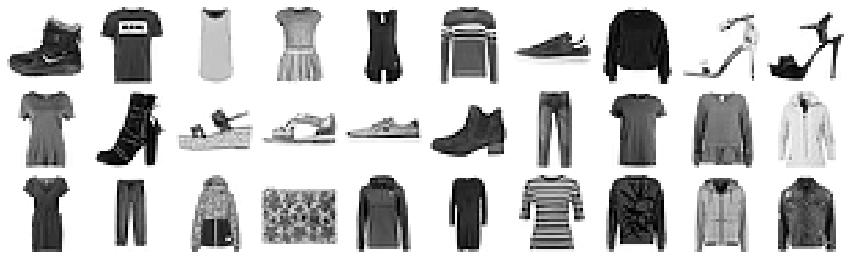

In [4]:
from matplotlib import pyplot as plt
from math import ceil

def show_images(images):
    """Show images in a grid
    """
    n_rows = ceil(len(images) / 10)
    fig, ax = plt.subplots(n_rows, 10, figsize=(15, 1.5 * n_rows),
                           subplot_kw={'xticks':[], 'yticks':[]},
                           gridspec_kw=dict(hspace=0.1, wspace=0.1))
    for i, _ in enumerate(images):
        # below we scale the pixel intensities back to display the images correctly
        ax[i // 10, i % 10].imshow(255 * images[i].reshape(28, 28), cmap='Greys')

show_images(train_images[:30])
plt.show();

# Model

## Preliminaries

In [0]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l1
from tensorflow.keras.backend import clear_session

We set the random seeds to get (as far as possible) reproducible results:

In [0]:
# Fix seeds for (hopefully) reproducible results
from numpy.random import seed
seed(14)
tf.random.set_seed(19)

## Hyperparameters

In [0]:
# Task parameters

input_size = 784
n_classes = 10

# Hyperparameters
#################

# dropout???
dropout_rate = 0.15

# regularization

#lambda_ = 0.0000
# regularizer = l1(lambda_)
regularizer = None 

# weight initialization
initializer = "random_normal"

# Model parameters
#################

# hidden_layers
hidden_layer_size = 256
n_hidden_layers = 5
hidden_layer_sizes = n_hidden_layers * [hidden_layer_size]

# activation function
activation_fun =  "sigmoid"

## Network

In [8]:
tf.compat.v1.reset_default_graph() # It's good practice to clea and reset everything
clear_session            # even using Keras


# Model
#######

x = Input(shape=(input_size,))

# Hidden layers

cur_last_layer = x

for n, _ in enumerate(hidden_layer_sizes):
    cur_last_layer = Dense(units=hidden_layer_sizes[n], 
                        activation=activation_fun,
                        kernel_regularizer=regularizer,
                        kernel_initializer=initializer,
                        bias_initializer=initializer)(cur_last_layer)
    
    cur_last_layer = Dropout(rate=dropout_rate)(cur_last_layer)

# Softmax 

predictions = Dense(n_classes, activation='softmax')(cur_last_layer)

# Full model

model = Model(inputs=x, outputs=predictions)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)      

## Loss, optimization and compilation

In [0]:
# Loss 

loss = sparse_categorical_crossentropy # we use this cross entropy variant as the input is not 
                                       # one-hot encoded

# Optimizer

optimizer = Adam() # A "smart" SGD variant 
 
# Compilation
#############

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

## Training

In [10]:

history = model.fit(x=train_images, y=train_labels,
                    validation_data=(valid_images, valid_labels),
                    epochs=20,
                    batch_size=100)

Train on 60000 samples, validate on 5000 samples
Epoch 1/20
60000/60000 [==============================] - 5s 79us/sample - loss: 1.3087 - acc: 0.4427 - val_loss: 1.0136 - val_acc: 0.5726
Epoch 2/20
60000/60000 [==============================] - 4s 71us/sample - loss: 1.0167 - acc: 0.5728 - val_loss: 0.9136 - val_acc: 0.6316
Epoch 3/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.9543 - acc: 0.6122 - val_loss: 0.8303 - val_acc: 0.6704
Epoch 4/20
60000/60000 [==============================] - 4s 70us/sample - loss: 0.8627 - acc: 0.6577 - val_loss: 0.7951 - val_acc: 0.6842
Epoch 5/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.8251 - acc: 0.6816 - val_loss: 0.7389 - val_acc: 0.7196
Epoch 6/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.7990 - acc: 0.6907 - val_loss: 0.7341 - val_acc: 0.7050
Epoch 7/20
60000/60000 [==============================] - 4s 71us/sample - loss: 0.7837 - acc: 0.6920 - val_loss: 0.6

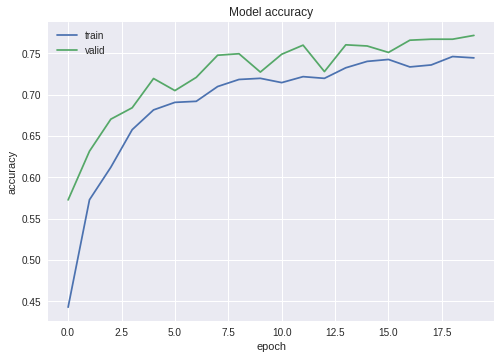

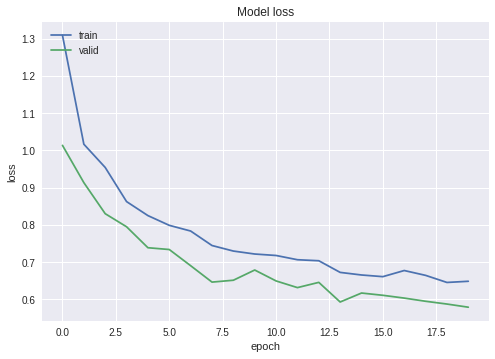

In [13]:
def display_history(history):
    """Summarize history for accuracy and loss.
    """
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'valid'], loc='upper left')
    plt.show()
    
display_history(history)

In [ ]:
assert max(history.history['accuracy'])>0.72
assert max(history.history['val_accuracy'])>0.73

## Saving the model

In [0]:
model.save('my_model.h5')  # creates a HDF5 file 'my_model.h5'
